In [1]:
import numpy as np
import time

def ProjectOntoL1Ball(v, b):
    """Projects vector v onto the L1 ball with radius b."""
    if b < 0:
        raise ValueError(f"Radius of L1 ball is negative: {b:.3f}")
    if np.linalg.norm(v, ord=1) <= b:
        return v.copy()
    u = np.sort(np.abs(v))[::-1]  # Descending order
    sv = np.cumsum(u)
    rho = np.where(u > (sv - b) / np.arange(1, len(u) + 1))[0]
    if rho.size == 0:
        theta = 0.0
    else:
        rho_idx = rho[-1]
        theta = (sv[rho_idx] - b) / (rho_idx + 1)
    w = np.sign(v) * np.maximum(np.abs(v) - theta, 0)
    return w

def DBGD(fun_f, grad_f, grad_g, fun_g, TSA, param, x0):
    """Dynamic Barrier Gradient Descent algorithm."""
    stepsize = param['stepsize']
    alpha = param['alpha']
    beta = param['beta']
    lambda_ = param['lam']  # Avoid 'lambda' keyword
    maxiter = param['maxiter']
    maxtime = param['maxtime']
    
    x = x0.copy()
    start_time = time.time()
    iter_count = 0
    f_vec1, g_vec1, time_vec1, acc_vec = [], [], [], []
    
    while iter_count <= maxiter:
        grad_f_x = grad_f(x)
        grad_g_x = grad_g(x)
        
        # Compute phi and weight (lambda_k)
        g_x = fun_g(x)
        grad_g_sq = np.dot(grad_g_x, grad_g_x)
        phi = min(alpha * g_x, beta * grad_g_sq)
        
        denominator = grad_g_sq
        if denominator == 0:
            weight = 0.0
        else:
            numerator = phi - np.dot(grad_f_x, grad_g_x)
            weight = max(numerator / denominator, 0.0)
        
        v = grad_f_x + weight * grad_g_x
        x = x - stepsize * v
        
        # Projection onto L1 ball
        x = ProjectOntoL1Ball(x, lambda_)
        
        # Record metrics
        elapsed = time.time() - start_time
        f_vec1.append(fun_f(x))
        g_vec1.append(fun_g(x))
        time_vec1.append(elapsed)
        acc_vec.append(TSA(x))
        
        # Log progress
        if iter_count % 5000 == 0:
            print(f"Iteration: {iter_count}")
        
        # Check time constraint
        if elapsed > maxtime:
            break
        
        iter_count += 1
    
    # Convert lists to numpy arrays
    return (
        np.array(f_vec1),
        np.array(g_vec1),
        np.array(time_vec1),
        x,
        np.array(acc_vec)
    )

# Example test functions
def example_f(x):
    return (x[0] - 1)**2 + (x[1] + 10)**2

def example_grad_f(x):
    return np.array([2*(x[0] - 1), 2*(x[1] + 10)])

def example_g(x):
    return (x[1] - np.sin(x[0]))**2

def example_grad_g(x):
    return np.array([
        -2 * np.cos(x[0]) * (x[1] - np.sin(x[0])),
        2 * (x[1] - np.sin(x[0]))
    ])

# Dummy test set accuracy function
def dummy_TSA(x):
    return 0.0

# Example parameters
param = {
    'stepsize': 0.01,
    'alpha': 0.1,
    'beta': 0.1,
    'lam': 1.0,
    'maxiter': 1000,
    'maxtime': 100  # seconds
}

# Initial point
x0 = np.array([0.0, 0.0])

# Run DBGD
f_values, g_values, time_values, x_final, acc_values = DBGD(
    example_f, example_grad_f, example_grad_g, example_g, dummy_TSA, param, x0
)

Iteration: 0


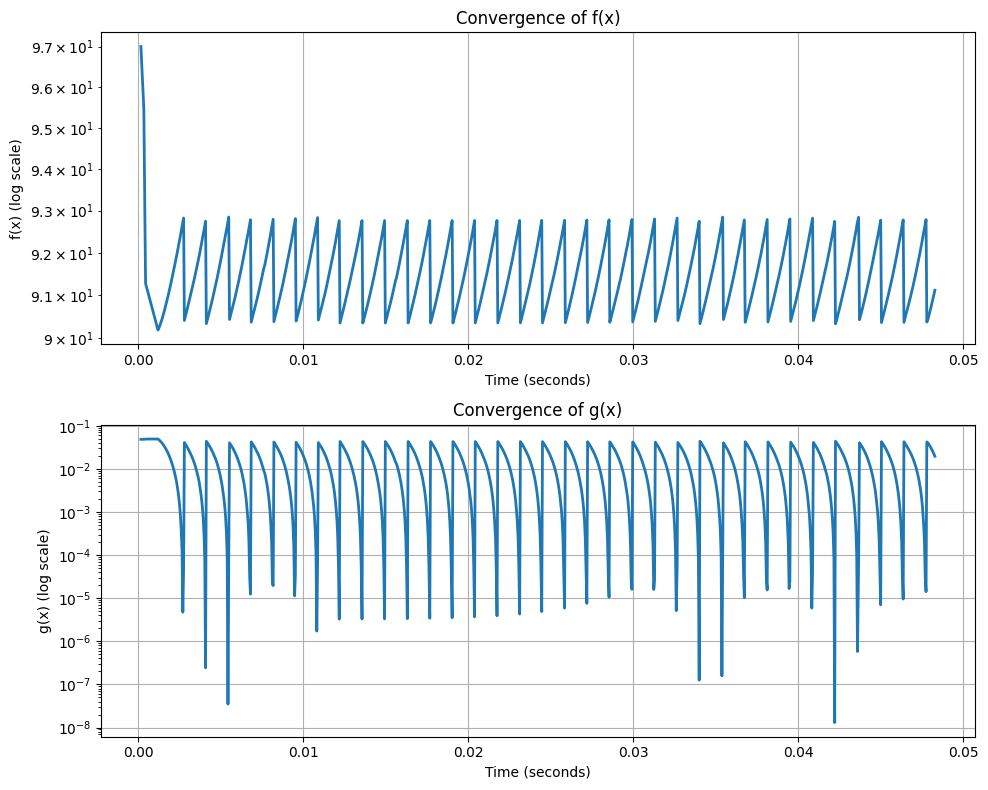

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot f(x) in first subplot
ax1.semilogy(time_values, f_values, linewidth=2)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('f(x) (log scale)')
ax1.set_title('Convergence of f(x)')
ax1.grid(True)

# Plot g(x) in second subplot
ax2.semilogy(time_values, g_values, linewidth=2)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('g(x) (log scale)')
ax2.set_title('Convergence of g(x)')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()